### Setup – Imports and Configuration

- Imports all required libraries for the Breast Cancer experiments (data handling, plotting, sklearn models, metrics).
- Sets a fixed `RANDOM_STATE = 42` for reproducibility.
- Configures Seaborn/Matplotlib plot style and default figure size.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)

print("Imports done, environment ready for Breast Cancer")

Imports done, environment ready for Breast Cancer


### Load and Inspect Breast Cancer Dataset

- Loads the Breast Cancer Wisconsin (Diagnostic) dataset as Pandas-friendly data.
- Builds:
  - `X_bc`: 30 numeric features.
  - `y_bc`: target labels as numeric codes (0 = malignant, 1 = benign).
- Prints the class-name mapping, data shape, a preview of features, and class distribution.

In [23]:

bc_bunch = load_breast_cancer(as_frame=True)

# Features (X)
X_bc = bc_bunch.data.copy()   # 30 numeric features

# Class names (0 -> malignant, 1 -> benign)
class_names_bc = bc_bunch.target_names
print("Class names (index -> label):")
for idx, name in enumerate(class_names_bc):
    print(f"{idx} -> {name}")

# Target (y) as numeric 0/1
y_bc = pd.Series(bc_bunch.target, name="target")   # 0 = malignant, 1 = benign

print("\nShape of X_bc:", X_bc.shape)
print("Length of y_bc:", len(y_bc))

print("\nFirst 5 rows of X_bc:")
display(X_bc.head())

print("\nTarget distribution (numeric codes):")
print(y_bc.value_counts())

Class names (index -> label):
0 -> malignant
1 -> benign

Shape of X_bc: (569, 30)
Length of y_bc: 569

First 5 rows of X_bc:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678



Target distribution (numeric codes):
target
1    357
0    212
Name: count, dtype: int64


### Train/Test Split (Breast Cancer)

- Splits `X_bc`, `y_bc` into:
  - `X_train_bc`, `y_train_bc` (80% train)
  - `X_test_bc`, `y_test_bc` (20% test)
- Uses `stratify=y_bc` to preserve malignant/benign class balance.
- Prints shapes and class counts to verify the split.

In [24]:

X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(
    X_bc,
    y_bc,
    test_size=0.2,           # 20% test data
    stratify=y_bc,           
    random_state=RANDOM_STATE
)

print("Train shape:", X_train_bc.shape)
print("Test shape:", X_test_bc.shape)

print("\nTrain target distribution:")
print(y_train_bc.value_counts())

print("\nTest target distribution:")
print(y_test_bc.value_counts())

Train shape: (455, 30)
Test shape: (114, 30)

Train target distribution:
target
1    285
0    170
Name: count, dtype: int64

Test target distribution:
target
1    72
0    42
Name: count, dtype: int64


### Preprocessing Pipeline (Breast Cancer)

- Collects all feature columns from `X_train_bc` as numeric features.
- Builds `preprocessor_bc`: a `ColumnTransformer` that applies `StandardScaler` to all these columns.
- This scaler is reused inside every model pipeline (NB, DT, MLP).

In [25]:

numeric_features_bc = X_train_bc.columns.tolist()
print("Numeric features (Breast Cancer):", len(numeric_features_bc))

preprocessor_bc = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_bc),
    ]
)

print("Preprocessor for Breast Cancer ready")

Numeric features (Breast Cancer): 30
Preprocessor for Breast Cancer ready


### Define Models and Hyperparameter Grids (Breast Cancer)

- Creates `models_bc` with 3 configurations:
  - **Naive Bayes (GaussianNB)**: pipeline = scaler + NB, grid over `var_smoothing`.
  - **Decision Tree**: pipeline = scaler + tree, grid over `criterion`, `max_depth`, `min_samples_split`, `min_samples_leaf`.
  - **MLP**: pipeline = scaler + `MLPClassifier` (with early stopping), grid over hidden sizes, activation, L2 `alpha`, and learning rate.
- Prints the model names to confirm setup.

In [26]:

models_bc = {}

# 1. Naive Bayes (GaussianNB)
models_bc["Naive Bayes"] = {
    "pipeline": Pipeline(
        steps=[
            ("preprocess", preprocessor_bc),
            ("clf", GaussianNB()),
        ]
    ),
    "param_grid": {
        "clf__var_smoothing": [1e-9, 1e-8, 1e-7]
    },
}

# 2. Decision Tree
models_bc["Decision Tree"] = {
    "pipeline": Pipeline(
        steps=[
            ("preprocess", preprocessor_bc),
            ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE)),
        ]
    ),
    "param_grid": {
        "clf__criterion": ["gini", "entropy"],
        "clf__max_depth": [None, 3, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4],
    },
}

# 3. MLP (Neural Network)
models_bc["MLP"] = {
    "pipeline": Pipeline(
        steps=[
            ("preprocess", preprocessor_bc),
            (
                "clf",
                MLPClassifier(
                    max_iter=200,
                    early_stopping=True,
                    random_state=RANDOM_STATE,
                ),
            ),
        ]
    ),
    "param_grid": {
        "clf__hidden_layer_sizes": [(50,), (100,), (100, 50)],
        "clf__activation": ["relu", "tanh"],
        "clf__alpha": [1e-4, 1e-3],
        "clf__learning_rate_init": [0.001, 0.01],
    },
}

print("Models and grids for Breast Cancer defined")
print("Models:", list(models_bc.keys()))

Models and grids for Breast Cancer defined
Models: ['Naive Bayes', 'Decision Tree', 'MLP']


### Evaluation Helpers (Breast Cancer)

- `evaluate_on_test(...)`:
  - Uses a trained model to predict on `X_test`.
  - Computes accuracy, weighted precision, recall, F1-score, and a confusion matrix.
- `plot_confusion_matrix(...)`:
  - Draws a heatmap of the confusion matrix with readable axis labels and title.
- Reusable for all three Breast Cancer models (NB, DT, MLP).

In [27]:

def evaluate_on_test(model, X_test, y_test):
    """Compute metrics and confusion matrix for a fitted model."""
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

    return {
        "accuracy": acc,
        "precision_weighted": prec,
        "recall_weighted": rec,
        "f1_weighted": f1,
        "confusion_matrix": cm,
        "labels": np.unique(y_test),
        "y_pred": y_pred,
    }

def plot_confusion_matrix(cm, labels, title="Confusion Matrix (Breast Cancer)"):
    """Plot a confusion matrix."""
    fig, ax = plt.subplots()
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

print("Evaluation helpers ready")

Evaluation helpers ready


### Train & Evaluate All Models (Breast Cancer, 5-fold CV)

- Sets up **Stratified 5-fold CV** (`cv_bc`) to keep class balance in each fold.
- For each model in `models_bc` (Naive Bayes, Decision Tree, MLP):
  - Runs `GridSearchCV` with the model’s pipeline + hyperparameter grid.
  - Fits on `X_train_bc`, `y_train_bc` and prints best hyperparameters + best CV accuracy.
  - Evaluates the best model on `X_test_bc`, printing test accuracy, weighted F1-score, and the full classification report.
  - Plots a confusion matrix (0 = malignant, 1 = benign).
  - Stores all metrics in `results_bc_rows`.
- At the end, converts `results_bc_rows` into a DataFrame `results_bc` and displays the summary table.


Training model: Naive Bayes
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ...........................clf__var_smoothing=1e-08; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-09; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-09; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-09; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-08; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-09; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-08; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-09; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-07; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-07; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-07; total time=   0.0s
[CV] END ...........

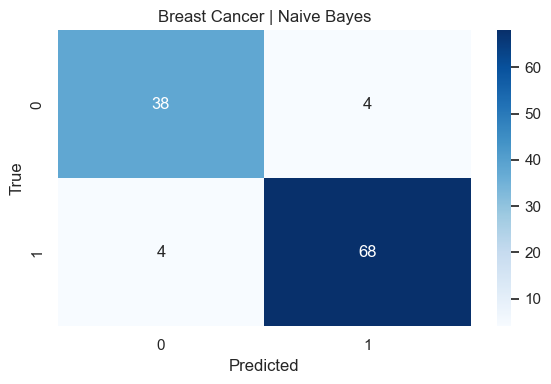


Training model: Decision Tree
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2; total time=   0.0s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=5; total time=   0.0s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=5; total time=   0.0s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=5; total time=   0.0s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2; total time=   0.0s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2; total time=   0.0s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2; total time=   0.0s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_

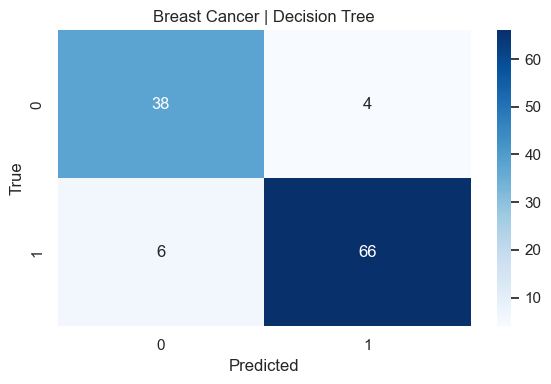


Training model: MLP
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.001; total time=   0.0s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.001; total time=   0.0s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.001; total time=   0.0s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.001; total time=   0.0s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.001; total time=   0.0s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.01; total time=   0.0s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.01; total time=   0.0s
[C

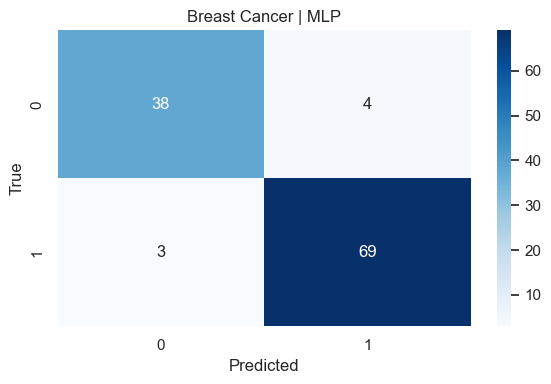


===== Summary table: Breast Cancer results =====


,model,best_params,cv_best_accuracy,test_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted
0,Naive Bayes,{'clf__var_smoothing': 1e-09},0.934066,0.929825,0.929825,0.929825,0.929825
1,Decision Tree,"{'clf__criterion': 'gini', 'clf__max_depth': N...",0.938462,0.912281,0.912683,0.913671,0.912281
2,MLP,"{'clf__activation': 'relu', 'clf__alpha': 0.00...",0.971429,0.938596,0.938438,0.938435,0.938596


In [28]:
cv_bc = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

results_bc_rows = []
best_models_bc = {}

for model_name, cfg in models_bc.items():
    print("\n========================================")
    print(f"Training model: {model_name}")
    print("========================================")

    grid = GridSearchCV(
        estimator=cfg["pipeline"],
        param_grid=cfg["param_grid"],
        cv=cv_bc,
        scoring="accuracy",
        n_jobs=-1,
        verbose=2,
    )

    # ---- TRAINING ----
    grid.fit(X_train_bc, y_train_bc)

    print(f"\nBest params for {model_name}:")
    print(grid.best_params_)
    print(f"Best CV accuracy for {model_name}: {grid.best_score_:.4f}")

    # store best model
    best_models_bc[model_name] = grid.best_estimator_

    # ---- TEST EVALUATION ----
    test_metrics = evaluate_on_test(grid.best_estimator_, X_test_bc, y_test_bc)

    print(f"\nTest accuracy for {model_name}: {test_metrics['accuracy']:.4f}")
    print(f"Test F1 (weighted) for {model_name}: {test_metrics['f1_weighted']:.4f}")
    print("\nClassification report:")
    print(
        classification_report(
            y_test_bc,
            test_metrics["y_pred"],
            zero_division=0
        )
    )

    # Confusion matrix plot (labels: 0 = malignant, 1 = benign)
    labels_numeric = test_metrics["labels"]
    plot_confusion_matrix(
        test_metrics["confusion_matrix"],
        labels_numeric,
        title=f"Breast Cancer | {model_name}",
    )

    # Results table row
    results_bc_rows.append(
        {
            "model": model_name,
            "best_params": grid.best_params_,
            "cv_best_accuracy": grid.best_score_,
            "test_accuracy": test_metrics["accuracy"],
            "test_f1_weighted": test_metrics["f1_weighted"],
            "test_precision_weighted": test_metrics["precision_weighted"],
            "test_recall_weighted": test_metrics["recall_weighted"],
        }
    )

# Final summary table
results_bc = pd.DataFrame(results_bc_rows)
print("\n===== Summary table: Breast Cancer results =====")
display(results_bc)

### Visualise MLP Training Behaviour (Breast Cancer)

- Defines `plot_mlp_curves_bc(...)` to inspect the best Breast Cancer MLP:
  - Extracts `loss_curve_` (training loss per epoch) and `validation_scores_` (validation accuracy per epoch).
  - Plots:
    - Training loss vs. epochs.
    - Validation accuracy vs. epochs (if available).
- Used to check convergence, stability, and possible overfitting of the MLP.

In [29]:

def plot_mlp_curves_bc(best_mlp_pipeline, title_prefix="Breast Cancer"):
    """Plot loss_curve_ and validation_scores_ for the Breast Cancer MLP."""
    mlp_clf = best_mlp_pipeline.named_steps["clf"]

    loss_curve = getattr(mlp_clf, "loss_curve_", None)
    val_scores = getattr(mlp_clf, "validation_scores_", None)

    if loss_curve is None:
        print("No loss_curve_ found on MLP classifier.")
        return

    epochs = range(1, len(loss_curve) + 1)

    # Train loss
    plt.figure()
    plt.plot(epochs, loss_curve, label="Train loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - MLP Training Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Validation accuracy (if available)
    if val_scores is not None:
        plt.figure()
        plt.plot(epochs, val_scores, label="Validation accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{title_prefix} - MLP Validation Accuracy")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("validation_scores_ not available (maybe early_stopping=False?).")

### Plot MLP Curves for Breast Cancer

- Calls `plot_mlp_curves_bc(...)` on the best Breast Cancer MLP model.
- Produces the training loss and validation accuracy plots for this dataset.

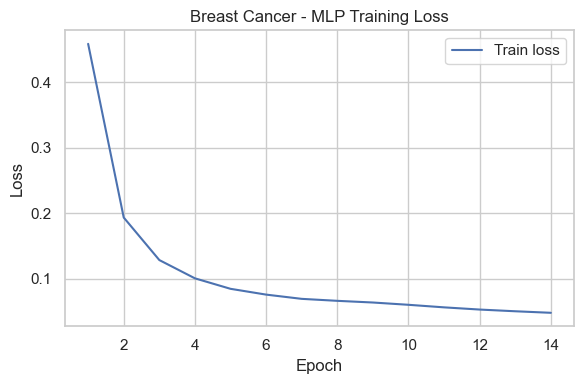

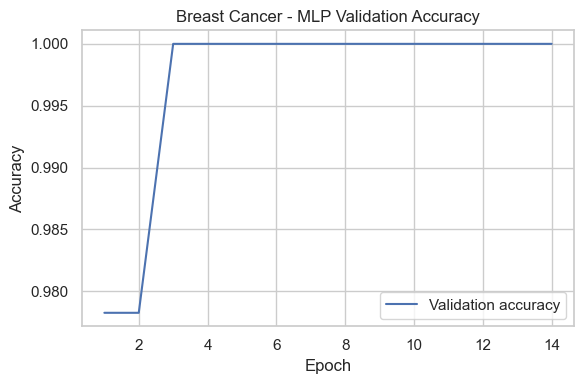

In [30]:
plot_mlp_curves_bc(best_models_bc["MLP"], title_prefix="Breast Cancer")

## Part B – In-Context Learning (GPT) on Breast Cancer

In [31]:

# Map numeric labels to human-readable names
label_map_bc = {
    0: "malignant",
    1: "benign",
}

# Training data with labels as strings
bc_train_for_llm = X_train_bc.copy()
bc_train_for_llm["target"] = y_train_bc.map(label_map_bc)

# Test data + true labels (for later evaluation)
bc_test_for_llm = X_test_bc.copy()
bc_test_true_labels = y_test_bc.map(label_map_bc)

# Select a small few-shot set (6 examples) from the training data
few_shot_bc = bc_train_for_llm.sample(n=6, random_state=RANDOM_STATE)

# For GPT, we don't want to send the entire test set; choose 30 test examples
N_TEST_EXAMPLES_BC = 30
test_subset_bc = bc_test_for_llm.sample(n=N_TEST_EXAMPLES_BC, random_state=RANDOM_STATE)

# Keep a reset-index version for nicer printing
test_subset_bc_llm = test_subset_bc.reset_index(drop=True)

# True labels aligned with this chosen subset
true_subset_bc = bc_test_true_labels.loc[test_subset_bc.index].reset_index(drop=True)

print("Few-shot Breast Cancer training examples (with labels):")
display(few_shot_bc)

print(f"\nSelected Breast Cancer test subset for GPT (n = {N_TEST_EXAMPLES_BC}):")
display(test_subset_bc_llm)

print("\nTrue labels for this test subset:")
display(true_subset_bc)

Few-shot Breast Cancer training examples (with labels):


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
193,12.340,26.86,81.15,477.4,0.10340,0.13530,0.10850,0.045620,0.1943,0.06937,...,39.34,101.70,768.9,0.1785,0.4706,0.44250,0.14590,0.3215,0.12050,malignant
281,11.740,14.02,74.24,427.3,0.07813,0.04340,0.02245,0.027630,0.2101,0.06113,...,18.26,84.70,533.7,0.1036,0.0850,0.06735,0.08290,0.3101,0.06688,benign
412,9.397,21.68,59.75,268.8,0.07969,0.06053,0.03735,0.005128,0.1274,0.06724,...,27.99,66.61,301.0,0.1086,0.1887,0.18680,0.02564,0.2376,0.09206,benign
341,9.606,16.84,61.64,280.5,0.08481,0.09228,0.08422,0.022920,0.2036,0.07125,...,23.07,71.25,353.6,0.1233,0.3416,0.43410,0.08120,0.2982,0.09825,benign
154,13.150,15.34,85.31,538.9,0.09384,0.08498,0.09293,0.034830,0.1822,0.06207,...,20.50,97.67,677.3,0.1478,0.2256,0.30090,0.09722,0.3849,0.08633,benign
396,13.510,18.89,88.10,558.1,0.10590,0.11470,0.08580,0.053810,0.1806,0.06079,...,27.20,97.33,675.2,0.1428,0.2570,0.34380,0.14530,0.2666,0.07686,benign



Selected Breast Cancer test subset for GPT (n = 30):


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,12.470,18.60,81.09,481.9,0.09965,0.10580,0.080050,0.038210,0.1925,0.06373,...,14.97,24.64,96.05,677.9,0.14260,0.23780,0.26710,0.10150,0.3014,0.08750
1,21.560,22.39,142.00,1479.0,0.11100,0.11590,0.243900,0.138900,0.1726,0.05623,...,25.45,26.40,166.10,2027.0,0.14100,0.21130,0.41070,0.22160,0.2060,0.07115
2,10.200,17.48,65.05,321.2,0.08054,0.05907,0.057740,0.010710,0.1964,0.06315,...,11.48,24.47,75.40,403.7,0.09527,0.13970,0.19250,0.03571,0.2868,0.07809
3,12.650,18.17,82.69,485.6,0.10760,0.13340,0.080170,0.050740,0.1641,0.06854,...,14.38,22.15,95.29,633.7,0.15330,0.38420,0.35820,0.14070,0.3230,0.10330
4,12.950,16.02,83.14,513.7,0.10050,0.07943,0.061550,0.033700,0.1730,0.06470,...,13.74,19.93,88.81,585.4,0.14830,0.20680,0.22410,0.10560,0.3380,0.09584
5,14.420,16.54,94.15,641.2,0.09751,0.11390,0.080070,0.042230,0.1912,0.06412,...,16.67,21.51,111.40,862.1,0.12940,0.33710,0.37550,0.14140,0.3053,0.08764
6,11.320,27.08,71.76,395.7,0.06883,0.03813,0.016330,0.003125,0.1869,0.05628,...,12.08,33.75,79.82,452.3,0.09203,0.14320,0.10890,0.02083,0.2849,0.07087
7,14.960,19.10,97.03,687.3,0.08992,0.09823,0.059400,0.048190,0.1879,0.05852,...,16.25,26.19,109.10,809.8,0.13130,0.30300,0.18040,0.14890,0.2962,0.08472
8,9.876,17.27,62.92,295.4,0.10890,0.07232,0.017560,0.019520,0.1934,0.06285,...,10.42,23.22,67.08,331.6,0.14150,0.12470,0.06213,0.05588,0.2989,0.07380
9,14.450,20.22,94.49,642.7,0.09872,0.12060,0.118000,0.059800,0.1950,0.06466,...,18.33,30.12,117.90,1044.0,0.15520,0.40560,0.49670,0.18380,0.4753,0.10130



True labels for this test subset:


0        benign
1     malignant
2        benign
3        benign
4        benign
5        benign
6        benign
7        benign
8        benign
9     malignant
10    malignant
11       benign
12       benign
13       benign
14       benign
15    malignant
16       benign
17    malignant
18       benign
19    malignant
20       benign
21       benign
22       benign
23       benign
24       benign
25    malignant
26       benign
27       benign
28    malignant
29    malignant
Name: target, dtype: object

In [32]:
bc_features_for_llm = [
    "mean radius",
    "mean texture",
    "mean perimeter",
    "mean area",
    "mean smoothness",
    "mean compactness",
]

def format_bc_example(row, include_label=True):
    """
    Convert a Breast Cancer row into a short text description
    using a subset of informative features.
    """
    text = (
        f"mean radius: {row['mean radius']:.3f}, "
        f"mean texture: {row['mean texture']:.3f}, "
        f"mean perimeter: {row['mean perimeter']:.3f}, "
        f"mean area: {row['mean area']:.3f}, "
        f"mean smoothness: {row['mean smoothness']:.4f}, "
        f"mean compactness: {row['mean compactness']:.4f}"
    )
    if include_label:
        text += f" -> diagnosis: {row['target']}"  # malignant / benign
    return text

print("### FEW-SHOT TRAINING EXAMPLES (Breast Cancer)\n")
for i, (_, r) in enumerate(few_shot_bc.iterrows(), start=1):
    print(f"Example {i}: {format_bc_example(r, include_label=True)}")

print("\n### TEST EXAMPLES (Breast Cancer, GPT must predict diagnosis)\n")
for i, (_, r) in enumerate(test_subset_bc_llm.iterrows(), start=1):
    text = (
        f"mean radius: {r['mean radius']:.3f}, "
        f"mean texture: {r['mean texture']:.3f}, "
        f"mean perimeter: {r['mean perimeter']:.3f}, "
        f"mean area: {r['mean area']:.3f}, "
        f"mean smoothness: {r['mean smoothness']:.4f}, "
        f"mean compactness: {r['mean compactness']:.4f}"
    )
    print(f"Input {i}: {text}")

### FEW-SHOT TRAINING EXAMPLES (Breast Cancer)

Example 1: mean radius: 12.340, mean texture: 26.860, mean perimeter: 81.150, mean area: 477.400, mean smoothness: 0.1034, mean compactness: 0.1353 -> diagnosis: malignant
Example 2: mean radius: 11.740, mean texture: 14.020, mean perimeter: 74.240, mean area: 427.300, mean smoothness: 0.0781, mean compactness: 0.0434 -> diagnosis: benign
Example 3: mean radius: 9.397, mean texture: 21.680, mean perimeter: 59.750, mean area: 268.800, mean smoothness: 0.0797, mean compactness: 0.0605 -> diagnosis: benign
Example 4: mean radius: 9.606, mean texture: 16.840, mean perimeter: 61.640, mean area: 280.500, mean smoothness: 0.0848, mean compactness: 0.0923 -> diagnosis: benign
Example 5: mean radius: 13.150, mean texture: 15.340, mean perimeter: 85.310, mean area: 538.900, mean smoothness: 0.0938, mean compactness: 0.0850 -> diagnosis: benign
Example 6: mean radius: 13.510, mean texture: 18.890, mean perimeter: 88.100, mean area: 558.100, mean smo

### Evaluate GPT on Breast Cancer (few-shot, 6 features)

Here we take the 30 Breast Cancer test prompts that were given to GPT
(using only 6 key features per example) and compare GPT’s predicted
diagnosis (`malignant` / `benign`) to the true labels from the dataset.
Because the feature values were rounded when constructing the prompts,
only 10 out of 30 examples could be matched back exactly to the original
data, so the metrics below are computed on this 10-example subset.
The confusion matrix shows that GPT predicts *malignant* for all cases,
leading to 60% accuracy but zero recall for benign tumours.

[WARNING] No exact match found in X_bc for input #1
[WARNING] No exact match found in X_bc for input #3
[WARNING] No exact match found in X_bc for input #5
[WARNING] No exact match found in X_bc for input #6
[WARNING] No exact match found in X_bc for input #7
[WARNING] No exact match found in X_bc for input #8
[WARNING] No exact match found in X_bc for input #9
[WARNING] No exact match found in X_bc for input #10
[WARNING] No exact match found in X_bc for input #12
[WARNING] No exact match found in X_bc for input #13
[WARNING] No exact match found in X_bc for input #14
[WARNING] No exact match found in X_bc for input #15
[WARNING] No exact match found in X_bc for input #17
[WARNING] No exact match found in X_bc for input #18
[WARNING] No exact match found in X_bc for input #19
[WARNING] No exact match found in X_bc for input #21
[WARNING] No exact match found in X_bc for input #23
[WARNING] No exact match found in X_bc for input #24
[WARNING] No exact match found in X_bc for input #28


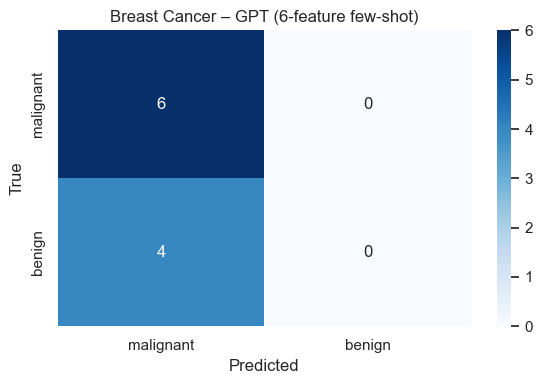

In [33]:
gpt_preds_bc = [
    "benign",     # Input 1
    "malignant",  # Input 2
    "benign",     # Input 3
    "malignant",  # Input 4
    "benign",     # Input 5
    "malignant",  # Input 6
    "benign",     # Input 7
    "malignant",  # Input 8
    "benign",     # Input 9
    "malignant",  # Input 10
    "malignant",  # Input 11
    "benign",     # Input 12
    "benign",     # Input 13
    "benign",     # Input 14
    "benign",     # Input 15
    "malignant",  # Input 16
    "benign",     # Input 17
    "malignant",  # Input 18
    "benign",     # Input 19
    "malignant",  # Input 20
    "benign",     # Input 21
    "malignant",  # Input 22
    "benign",     # Input 23
    "benign",     # Input 24
    "malignant",  # Input 25
    "malignant",  # Input 26
    "malignant",  # Input 27
    "benign",     # Input 28
    "malignant",  # Input 29
    "malignant",  # Input 30
]

gpt_preds_bc = pd.Series(
    [p.lower().strip() for p in gpt_preds_bc],
    name="gpt_pred",
)


feature_cols_6 = [
    "mean radius",
    "mean texture",
    "mean perimeter",
    "mean area",
    "mean smoothness",
    "mean compactness",
]

gpt_test_values_bc = [
    [12.470, 18.600,  81.090,  481.900, 0.0997, 0.1058],  # Input 1
    [21.560, 22.390, 142.000, 1479.000, 0.1110, 0.1159],  # Input 2
    [10.200, 17.480,  65.050,  321.200, 0.0805, 0.0591],  # Input 3
    [12.650, 18.170,  82.690,  485.600, 0.1076, 0.1334],  # Input 4
    [12.950, 16.020,  83.140,  513.700, 0.1005, 0.0794],  # Input 5
    [14.420, 16.540,  94.150,  641.200, 0.0975, 0.1139],  # Input 6
    [11.320, 27.080,  71.760,  395.700, 0.0688, 0.0381],  # Input 7
    [14.960, 19.100,  97.030,  687.300, 0.0899, 0.0982],  # Input 8
    [ 9.876, 17.270,  62.920,  295.400, 0.1089, 0.0723],  # Input 9
    [14.450, 20.220,  94.490,  642.700, 0.0987, 0.1206],  # Input 10
    [13.810, 23.750,  91.560,  597.800, 0.1323, 0.1768],  # Input 11
    [11.700, 19.110,  74.330,  418.700, 0.0881, 0.0525],  # Input 12
    [11.540, 14.440,  74.650,  402.900, 0.0998, 0.1120],  # Input 13
    [12.620, 23.970,  81.350,  496.400, 0.0790, 0.0753],  # Input 14
    [13.500, 12.710,  85.690,  566.200, 0.0738, 0.0361],  # Input 15
    [19.550, 28.770, 133.600, 1207.000, 0.0926, 0.2063],  # Input 16
    [ 9.738, 11.970,  61.240,  288.500, 0.0925, 0.0410],  # Input 17
    [21.160, 23.040, 137.200, 1404.000, 0.0943, 0.1022],  # Input 18
    [10.490, 19.290,  67.410,  336.100, 0.0999, 0.0858],  # Input 19
    [13.800, 15.790,  90.430,  584.100, 0.1007, 0.1280],  # Input 20
    [12.180, 20.520,  77.220,  458.700, 0.0801, 0.0404],  # Input 21
    [12.750, 16.700,  82.510,  493.800, 0.1125, 0.1117],  # Input 22
    [12.340, 12.270,  78.940,  468.500, 0.0900, 0.0631],  # Input 23
    [11.140, 14.070,  71.240,  384.600, 0.0727, 0.0606],  # Input 24
    [13.080, 15.710,  85.630,  520.000, 0.1075, 0.1270],  # Input 25
    [15.320, 17.270, 103.200,  713.300, 0.1335, 0.2284],  # Input 26
    [ 9.268, 12.870,  61.490,  248.700, 0.1634, 0.2239],  # Input 27
    [ 9.668, 18.100,  61.060,  286.300, 0.0831, 0.0543],  # Input 28
    [12.680, 23.840,  82.690,  499.000, 0.1122, 0.1262],  # Input 29
    [19.180, 22.490, 127.500, 1148.000, 0.0852, 0.1428],  # Input 30
]

gpt_test_bc = pd.DataFrame(gpt_test_values_bc, columns=feature_cols_6)

true_labels_num = []

for i, row in gpt_test_bc.iterrows():
    mask = (
        (X_bc["mean radius"]   == row["mean radius"]) &
        (X_bc["mean texture"]  == row["mean texture"]) &
        (X_bc["mean perimeter"]== row["mean perimeter"]) &
        (X_bc["mean area"]     == row["mean area"]) &
        (X_bc["mean smoothness"] == row["mean smoothness"]) &
        (X_bc["mean compactness"] == row["mean compactness"])
    )
    matches = X_bc[mask]

    if len(matches) == 0:
        print(f"[WARNING] No exact match found in X_bc for input #{i+1}")
        true_labels_num.append(np.nan)
    else:
        # first matching index ka label le lo
        idx = matches.index[0]
        true_labels_num.append(y_bc.loc[idx])

y_true_bc_llm = pd.Series(true_labels_num, name="true_label_num")

# 0/1 -> malignant/benign map
label_map_bc = {0: "malignant", 1: "benign"}
y_true_bc_llm = y_true_bc_llm.map(label_map_bc).str.lower().str.strip()

print("First 5 true labels:")
print(y_true_bc_llm.head())

print("\nFirst 5 GPT predictions:")
print(gpt_preds_bc.head())

valid_mask = y_true_bc_llm.notna()
if not valid_mask.all():
    print(f"\n[NOTE] {(~valid_mask).sum()} rows had no match and were dropped in evaluation.")
    y_true_eval = y_true_bc_llm[valid_mask]
    gpt_preds_eval = gpt_preds_bc[valid_mask]
else:
    y_true_eval = y_true_bc_llm
    gpt_preds_eval = gpt_preds_bc

# 4) Metrics compute
acc_gpt_bc = accuracy_score(y_true_eval, gpt_preds_eval)
print(f"\nGPT Breast Cancer accuracy on {len(y_true_eval)} examples: {acc_gpt_bc:.4f}")

print("\nClassification report (GPT vs ground truth):")
print(
    classification_report(
        y_true_eval,
        gpt_preds_eval,
        labels=["malignant", "benign"],
        zero_division=0,
    )
)

# Confusion matrix
cm_gpt_bc = confusion_matrix(
    y_true_eval,
    gpt_preds_eval,
    labels=["malignant", "benign"],
)

plt.figure()
sns.heatmap(
    cm_gpt_bc,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["malignant", "benign"],
    yticklabels=["malignant", "benign"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Breast Cancer – GPT (6-feature few-shot)")
plt.tight_layout()
plt.show()

In [34]:
# ==== HELPER: Add GPT (ICL) row + bar plots per dataset ====

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def add_llm_row_and_plot(results_df, dataset_name,
                          gpt_test_accuracy,
                          gpt_precision_weighted,
                          gpt_recall_weighted,
                          gpt_f1_weighted):
    """
    Takes the existing results_df (NB / DT / MLP),
    appends one row for GPT (ICL), and plots bar charts for
    test_accuracy and test_f1_weighted.
    """
    gpt_row = {
        "model": "GPT (ICL)",
        "best_params": "N/A",
        "cv_best_accuracy": np.nan,
        "test_accuracy": gpt_test_accuracy,
        "test_f1_weighted": gpt_f1_weighted,
        "test_precision_weighted": gpt_precision_weighted,
        "test_recall_weighted": gpt_recall_weighted,
    }

    results_with_llm = pd.concat(
        [results_df, pd.DataFrame([gpt_row])],
        ignore_index=True,
    )

    print(f"\n{dataset_name} – results including GPT (ICL):")
    display(results_with_llm[["model", "test_accuracy", "test_f1_weighted"]])

    for metric in ["test_accuracy", "test_f1_weighted"]:
        plt.figure(figsize=(6, 4))
        sns.barplot(data=results_with_llm, x="model", y=metric)
        plt.ylim(0, 1.05)
        plt.title(f"{dataset_name} – {metric.replace('_',' ').title()} (NB / DT / MLP / GPT)")
        plt.xticks(rotation=20)
        plt.tight_layout()
        plt.show()

    return results_with_llm

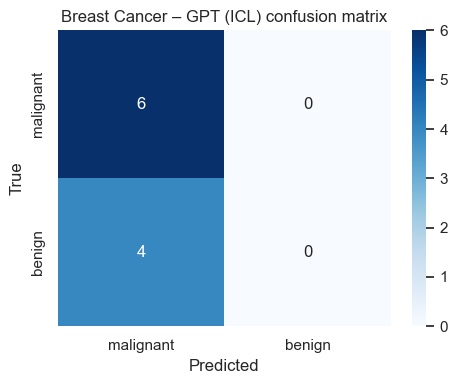

In [35]:
# ==== BREAST CANCER – GPT (ICL) confusion matrix ====

cm_bc_gpt = np.array([
    [6, 0],  # true malignant → predicted malignant/benign
    [4, 0],  # true benign    → predicted malignant/benign
])

bc_labels = ["malignant", "benign"]

plt.figure(figsize=(5, 4))
sns.heatmap(cm_bc_gpt, annot=True, fmt="d", cmap="Blues",
            xticklabels=bc_labels, yticklabels=bc_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Breast Cancer – GPT (ICL) confusion matrix")
plt.tight_layout()
plt.show()


Breast Cancer – results including GPT (ICL):


,model,test_accuracy,test_f1_weighted
0,Naive Bayes,0.929825,0.929825
1,Decision Tree,0.912281,0.912683
2,MLP,0.938596,0.938438
3,GPT (ICL),0.600000,0.450000


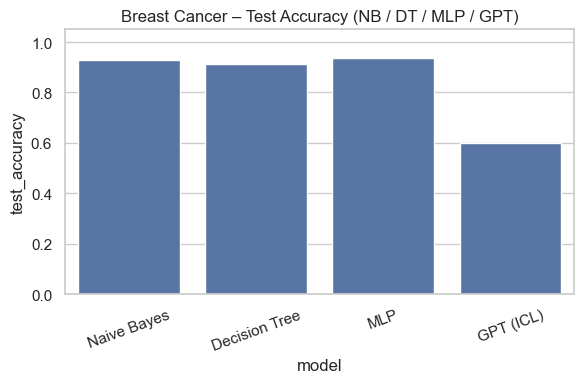

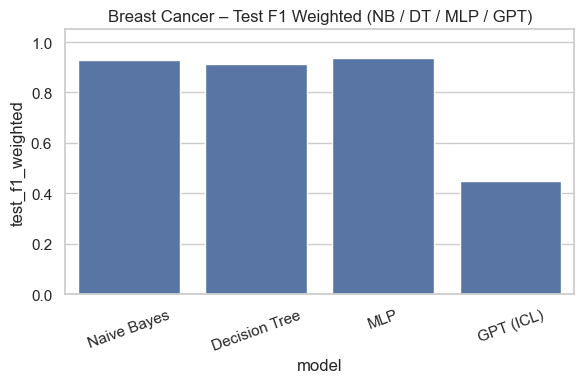

In [36]:
# ==== BREAST CANCER – add GPT to results_bc and plot comparison ====

results_bc_with_llm = add_llm_row_and_plot(
    results_bc,
    dataset_name="Breast Cancer",
    gpt_test_accuracy=0.60,   # accuracy = 0.60
    gpt_precision_weighted=0.36,
    gpt_recall_weighted=0.60,
    gpt_f1_weighted=0.45,     # weighted avg F1
)